In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from embedding import Embedding
from forward_kinematic import ForwardKinematic
from dynamical_system import DynamicalSystem

# DS

In [2]:
# DS parameters
config_dim = 2
K = np.eye(config_dim)
D = 2*np.eye(config_dim)
config_attractor = np.array([0.6, 0.15])

# Embedding parameters
x = torch.tensor([[-0.5], [1.8], [0.]])
mu = torch.tensor([[[0.], [0.5], [0.]], [[0.], [0.51], [0.]]])
sigma = torch.tensor([[[0.0112, 0.0024, 0], [0.0024, 0.0915, 0], [0, 0, 1]], [[0.01, 0.0034, 0], [0.0034, 0.0966, 0.], [0, 0, 1]]])

fk = ForwardKinematic(urdf_file='2_joints_arm.urdf', mu=mu.numpy(), sigma=sigma.numpy())

e = Embedding(dimension=2, x=x.repeat((1, 1, 1)), initial_mu=mu, initial_sigma=sigma, fk=fk)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e)

In [3]:
# start = np.array([0.23, -0.15])
start = np.array([-0.4, 0.3])
initial_speed = np.array([0., -0.])
x = start
dx = initial_speed
positions = []
for i in range(0,800):
    # start1 = time.time()
    x, dx = ds(x, dx)
    # if dx[0] < 0:
    #     print(i)
    #     break
    positions.append(x)
    # print(f'execution frequency of forward : {1/(time.time() - start1):.4f} Hz')
    # print(x)
#     res = fk.test(q=start)
#     # res = fk(start)
    # ds.compute_acceleration(x=start, dx=initial_speed)

/home/bbosc/Code/pdm/vane/dynamical_system.py:80: RuntimeWarning: overflow encountered in exp
  return (k-a) / (1 + np.exp(-b*(x-m))) + a


# FK + Embedding

In [4]:
q1 = np.linspace(-np.pi/2, np.pi/2, 100)
q2 = q1.copy()
gridX, gridY = np.meshgrid(q1, q2)
grid = np.column_stack((gridX.ravel(), gridY.ravel()))
print(grid.shape)

(10000, 2)


In [5]:
a = np.zeros((grid.shape[0], 3))
freq = []
for i, q in enumerate(grid):
    start = time.time()
    mus, sigmas, dmus, dsigmas, ddmus, ddsigmas = e.fk.test(q)
    e.update_parameters(mu=mus, sigma=sigmas)
    a[i] = np.array([q[0], q[1], e.n_value.sum()])
    freq.append(1/(time.time() - start))
print(f'average freq : {sum(freq)/len(freq)}')

average freq : 3325.2685064271095


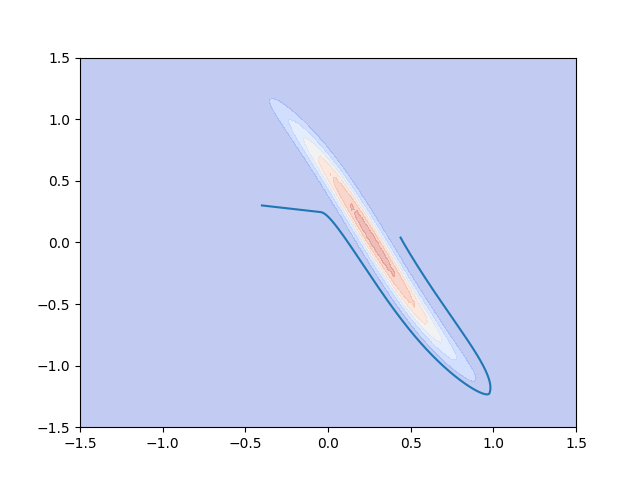

In [6]:
x1 = np.unique(a[:, 0])
x2 = np.unique(a[:, 1])
z = a[:, 2].reshape((x1.shape[0], x2.shape[0]))

ps= np.stack(positions)
%matplotlib widget
plt.figure()
plt.contourf(x1, x2,z, cmap=cm.coolwarm, alpha=0.35)
plt.plot(ps[:, 0], ps[:, 1])
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.show()

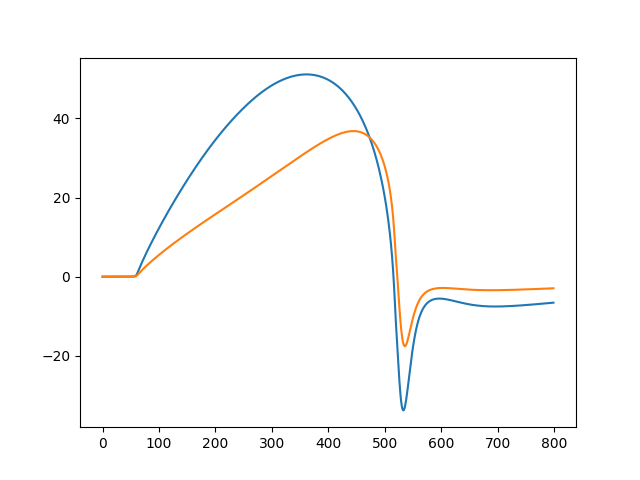

In [7]:
grad =np.stack(ds.gradient_logger)
plt.figure()
plt.plot(range(len(ds.gradient_logger)), grad[:, :, 0])
plt.plot(range(len(ds.gradient_logger)), grad[:, :, 1])
plt.show()

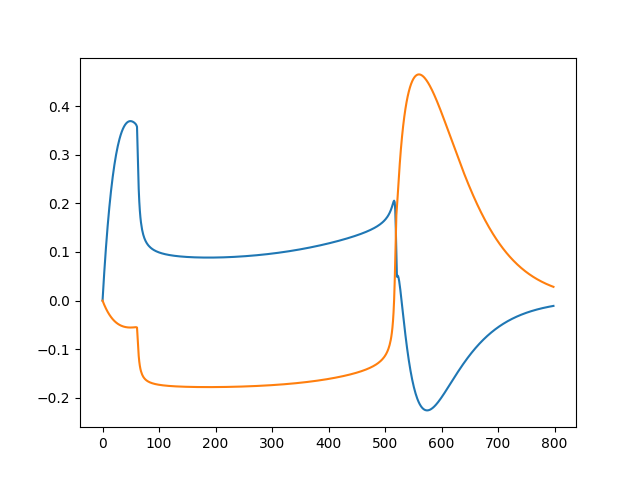

In [8]:
start = 0
end = -1

speed =np.stack(ds.speed_logger)[start :end ]
plt.figure()
plt.plot(range(speed.shape[0]), speed[:, 0])
plt.plot(range(speed.shape[0]), speed[:, 1])
plt.show()

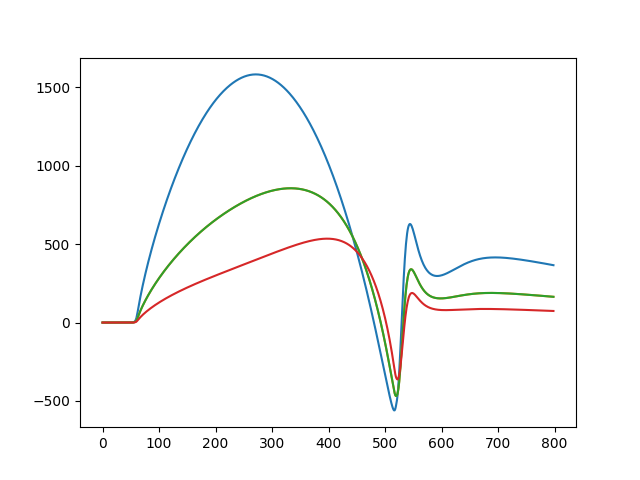

In [9]:
hess =np.stack(ds.hessian_logger)[start :end ]
plt.figure()
plt.plot(range(hess.shape[0]), hess[:, 0, 0])
plt.plot(range(hess.shape[0]), hess[:, 1, 0])
plt.plot(range(hess.shape[0]), hess[:, 0, 1])
plt.plot(range(hess.shape[0]), hess[:, 1, 1])
# plt.ylim([-820, 420])
plt.show()

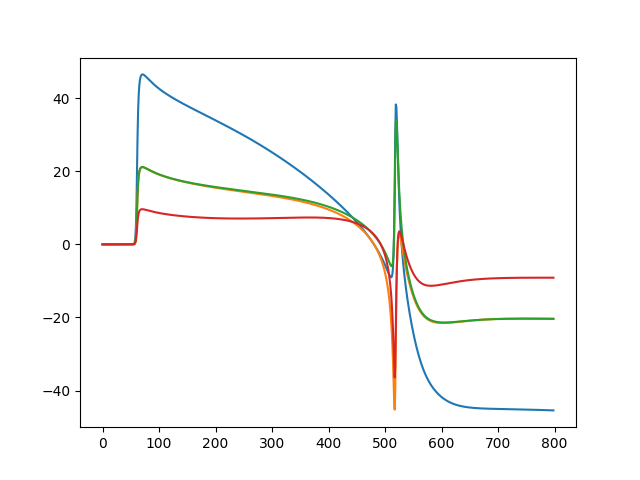

In [10]:
chr =np.stack(ds.christ_logger)[start :end ]
plt.figure()
plt.plot(range(hess.shape[0]), chr[:, 0, 0, 0])
plt.plot(range(hess.shape[0]), chr[:, 1, 0, 0])
plt.plot(range(hess.shape[0]), chr[:, 0, 1, 0])
plt.plot(range(hess.shape[0]), chr[:, 1, 1, 0])

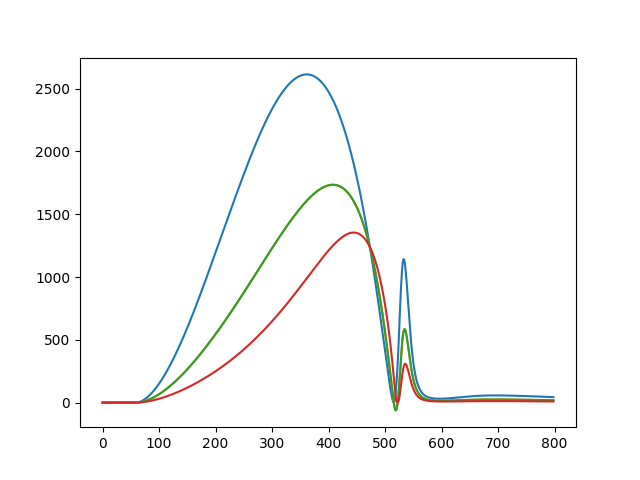

In [11]:
metric =np.stack(ds.metric_logger)[start :end ]
plt.figure()
plt.plot(range(hess.shape[0]), metric[:, 0, 0])
plt.plot(range(hess.shape[0]), metric[:, 0, 1])
plt.plot(range(hess.shape[0]), metric[:, 1, 0])
plt.plot(range(hess.shape[0]), metric[:, 1, 1])

In [12]:
metric.shape

(799, 2, 2)